In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

colsToUse = ['parcelid', 'latitude', 'longitude', 'yearbuilt']
filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename, usecols = colsToUse)

In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

all_df = trainid_df.join(properties_df)

In [4]:
# Only use the necessary data.

all_df = all_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
all_df = all_df.dropna()

npoints = len(all_df.logerror.values)
origerror = np.mean(np.abs(all_df.logerror.values))

In [5]:
# Make function for binning values in an array

def makebins(X, nbins = 50):
    X2 = X.copy()
    maxval = np.amax(X2)
    minval = np.amin(X2)
    X2 = (X2 - minval) / (maxval - minval) * nbins
    X2 = X2.astype(int)
    X2 = minval + X2 * (maxval - minval) / nbins
    return X2

In [6]:
# What is baseline median of logerrors.

np.median(all_df.logerror.values)

0.0060000000000000001

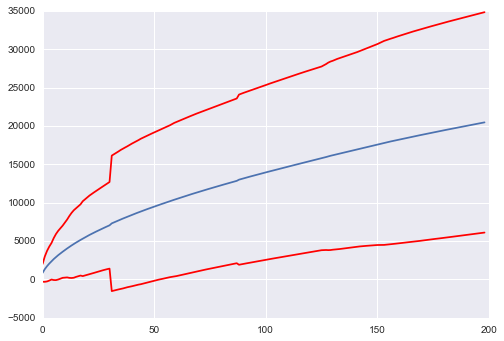

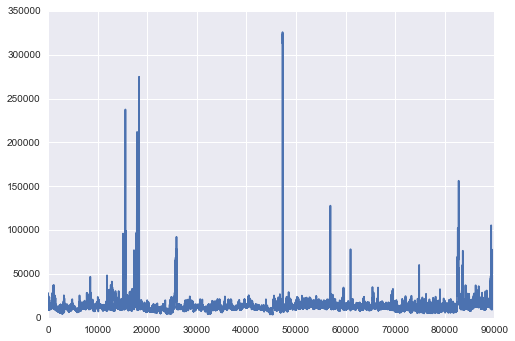

In [7]:
# Get statistics on neighbors for yearbuilt and distance

k = 200

coords = all_df[['latitude', 'longitude']].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
nbrdistance = nbrdistance[:,1:]
nbrindex = nbrindex[:,1:]

meandistance = np.mean(nbrdistance, axis = 0)
stddistance = np.std(nbrdistance, axis = 0)
plt.plot(meandistance)
plt.plot(meandistance + stddistance, color = 'red')
plt.plot(meandistance - stddistance, color = 'red')
plt.show()

meandistance = np.mean(nbrdistance, axis = 1)
plt.plot(meandistance)
plt.show()

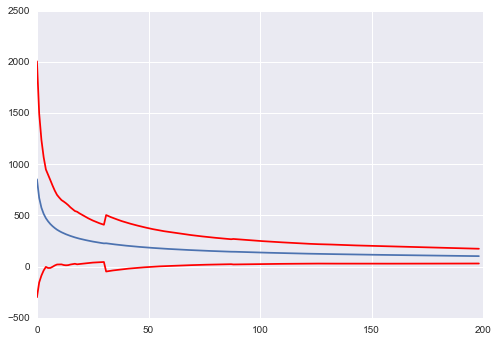

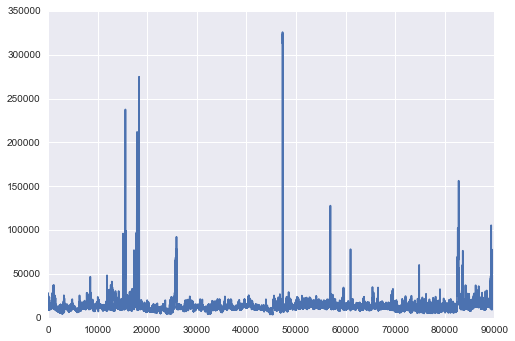

In [8]:
# Get statistics on neighbors for yearbuilt and distance

X = nbrdistance / np.arange(1.0, len(nbrdistance[0]) + 1, 1.0)

meandistance = np.mean(X, axis = 0)
stddistance = np.std(X, axis = 0)
plt.plot(meandistance)
plt.plot(meandistance + stddistance, color = 'red')
plt.plot(meandistance - stddistance, color = 'red')
plt.show()

meandistance = np.mean(nbrdistance, axis = 1)
plt.plot(meandistance)
plt.show()

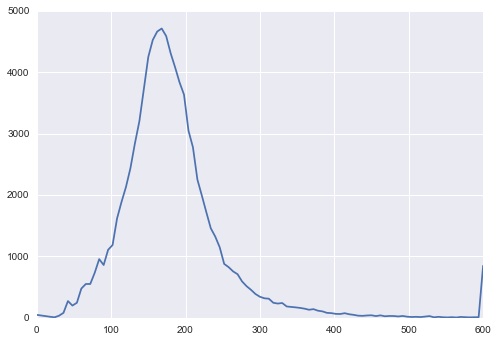

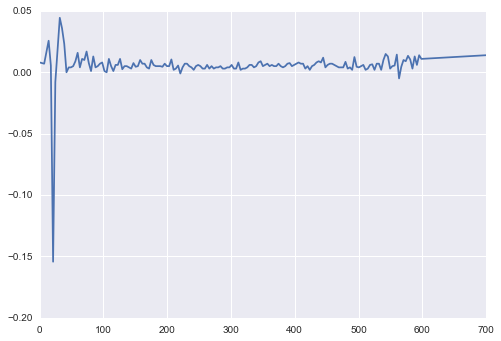

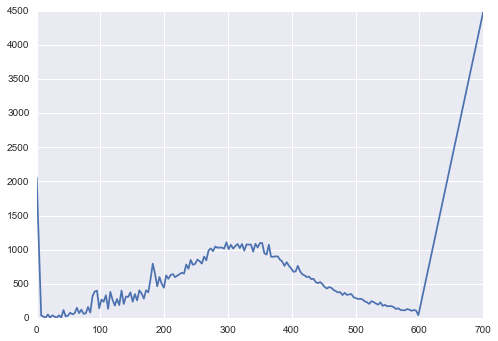

In [9]:
Y = X[:, 45]

Y[Y > 600] = 600
Y = makebins(Y, nbins = 100)
vals, counts = np.unique(Y, return_counts = True)
plt.plot(vals, counts)
plt.show()

Y = X[:, 10]
Y[Y > 600] = 700
bins = makebins(Y, nbins = 200)
all_df['bins'] = bins

grouped_df = all_df.groupby('bins').median()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

grouped_df = all_df.groupby('bins').count()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

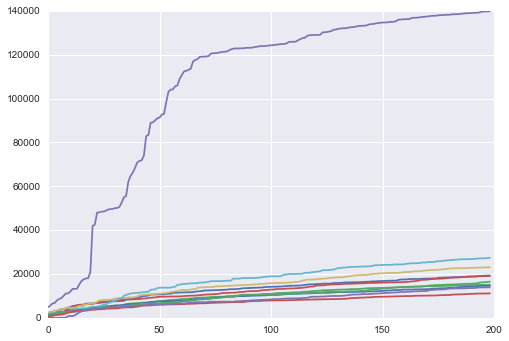

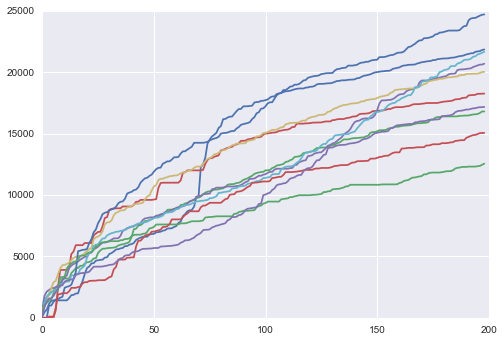

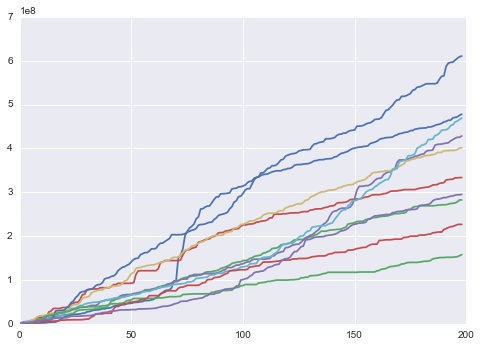

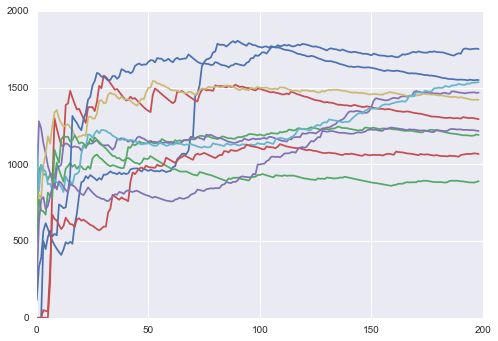

In [10]:
# Look at some graphs of neighbordistance.
rows = [39443, 26731, 86762, 17919, 57678,  7432,  6010, 73658, 20642, 47720]
#rows = np.random.randint(len(nbrdistance), size = 10)

Y = nbrdistance[rows]
for row in Y:
    plt.plot(row)
plt.show()

rows = [73565, 60366, 43489,  7169, 58025, 17280, 58166, 22021, 33973, 70549]
Y = nbrdistance[rows]
for row in Y:
    plt.plot(row)
plt.show()

for row in Y:
    plt.plot(row**2)
plt.show()


num = np.arange(1,len(nbrdistance[0])+1,1.0)
for row in Y:
    plt.plot(row / np.sqrt(num))
plt.show()


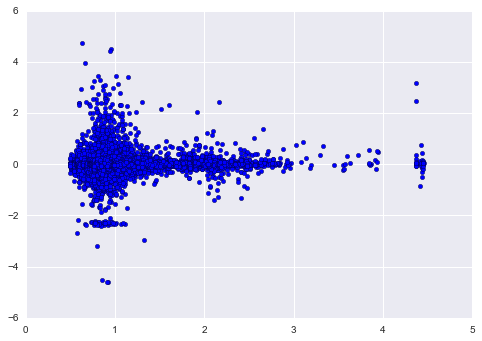

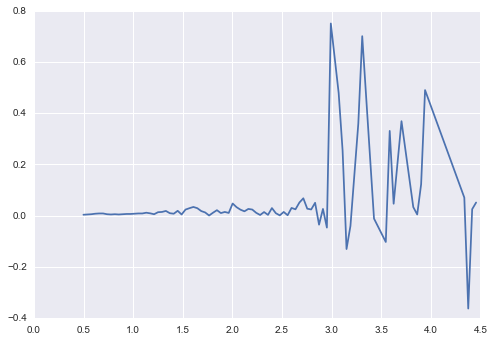

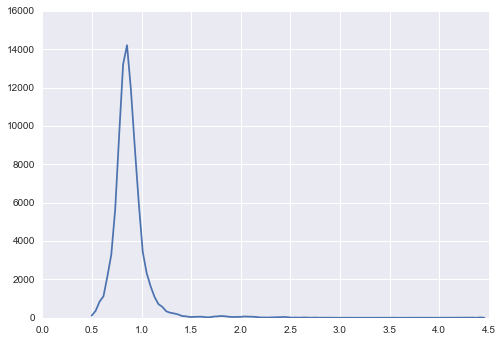

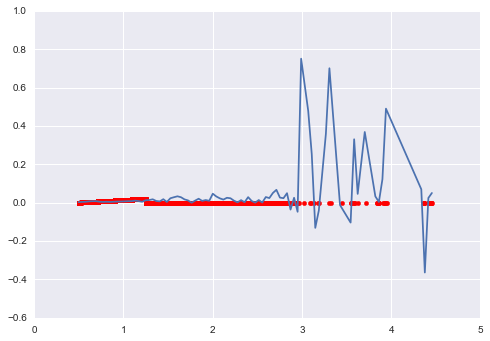

0.0679434418165
0.000661933511311


In [38]:
# Let's look at average square root / nbrdistance for range of neighbors.

nbra = 100
nbrb = 190
X = nbrdistance[:, nbra:nbrb]
nbrnum = np.arange(nbra, nbrb, 1.0)
X = np.sqrt(X) / nbrnum
X = np.mean(X, axis = 1)

y = all_df.logerror.values

plt.scatter(X, y)
plt.show()

# Now let's bin
bins = makebins(X, nbins = 100)
all_df['bins'] = bins
grouped_df = all_df.groupby('bins').median()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

grouped_df = all_df.groupby('bins').count()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

# Now let's try a linear fit for those with X not too large
cutoff = 1.25

linear = linear_model.LinearRegression()
Xf = X[X < cutoff].reshape(-1,1)
yf = y[X < cutoff].reshape(-1,1)
linear.fit(Xf, yf)

grouped_df = all_df.groupby('bins').median()

yp = np.zeros(len(y)).reshape(-1,1)
yp[X < cutoff] = linear.predict(X[X < cutoff].reshape(-1,1))
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.scatter(X, yp, color = 'red')
plt.show()

error = np.abs(yp - y.reshape(-1,1))
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

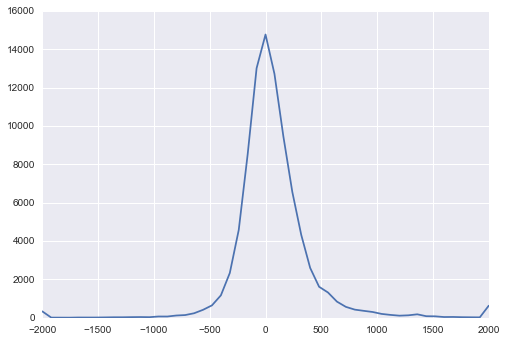

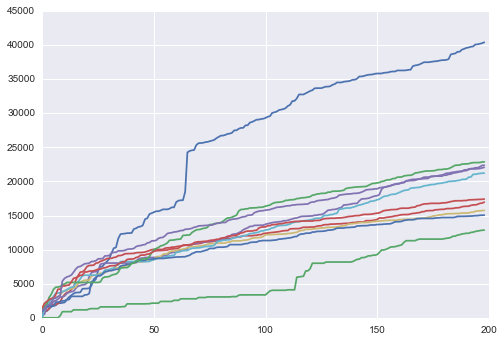

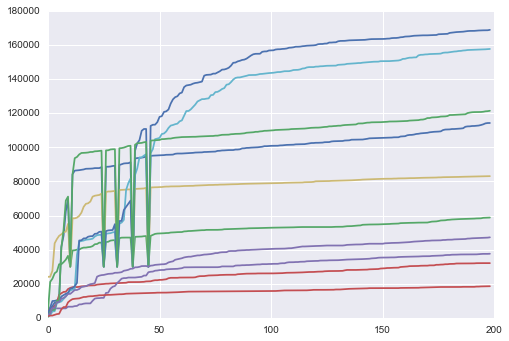

In [46]:
# Let's try to find the rows in neighbor distance with the step phenomenon.
a = 50
b = 190
X = nbrdistance[:, b] / np.sqrt(b) - nbrdistance[:, a] / np.sqrt(a)

Y = X.copy()
lowcutoff = -2 * 10**3
highcutoff = 2 * 10**3
Y[ Y < lowcutoff] = lowcutoff
Y[ Y > highcutoff] = highcutoff
Y = makebins(Y, nbins = 50)
vals, counts = np.unique(Y, return_counts = True)
plt.plot(vals, counts)
plt.show()

# Let's see if a cutoff on X given the steps

cutoff = 750
indices = X > cutoff
rowstotry = nbrdistance[indices]
rows = np.random.randint(len(rowstotry), size = 10)
for row in rows:
    plt.plot(nbrdistance[row])
plt.show()

# Let's see if a cutoff on X given the steps

indices = X < -cutoff
rowstotry = nbrdistance[indices]
rows = np.random.randint(len(rowstotry), size = 10)
for row in rows:
    plt.plot(rowstotry[row])
plt.show()

-0.125327026698


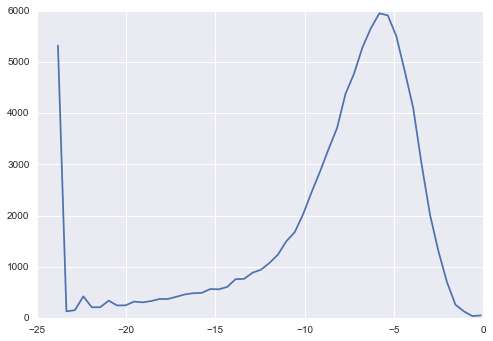

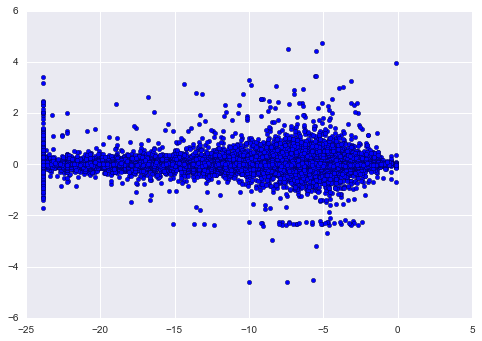

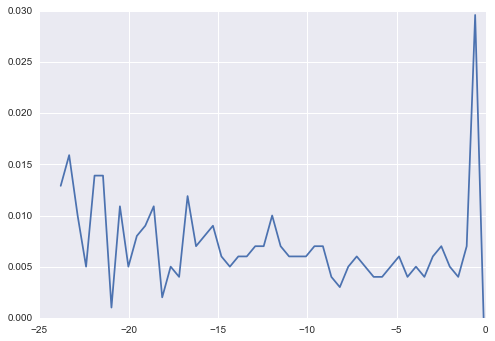

0.0676374356282
-0.00384488474691


In [71]:
# Let's try to find the weird spiking phenomenon.

nbra = 25
nbrb = 50
weight = np.arange(nbra, nbrb, 1.0)
weight = np.sqrt(weight)
X = nbrdistance[:, 25:50] / weight
Y = X[:,1:]
Z = X[:,:-1]
Y = Y - Z
Y[Y > 0] = 0.0
Y = np.mean(Y, axis = 1)
print(np.amax(Y))

cutoff = 10*10**3
#X[X > cutoff] = cutoff
bins = makebins(Y, nbins = 50)
vals, counts = np.unique(bins, return_counts = True)
plt.plot(vals, counts)
plt.show()

plt.scatter(Y, all_df.logerror.values)
plt.show()

all_df['bins'] = bins
grouped_df = all_df.groupby('bins').median()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

# Try a simple reduction

y = all_df.logerror.values
yp = np.zeros(len(y))
indices = (-10 < Y) & (Y < -2)
yp[indices] = 0.005
indices = (-20 < Y) & (Y <= -10)
yp[indices] = 0.006

error = np.abs(y - yp)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

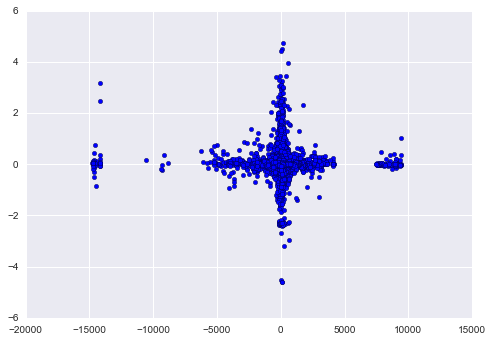

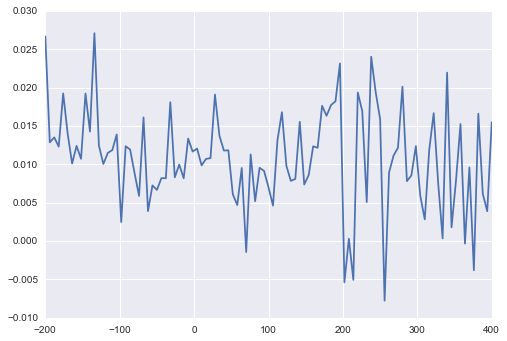

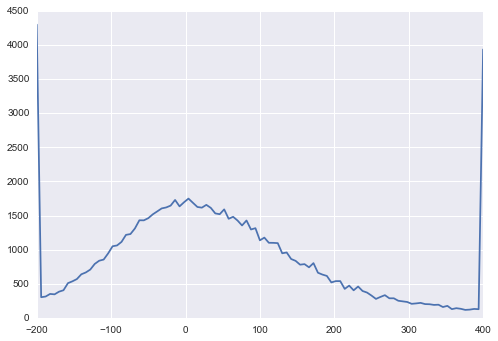

27451


In [48]:
# Let's look at the log error versus this scaled difference.

a = 50
b = 100
X = nbrdistance[:, b] / np.sqrt(b) - nbrdistance[:, a] / np.sqrt(a)

all_df['nbrDifference'] = X
plt.scatter(all_df.nbrDifference.values, all_df.logerror.values)
plt.show()

lowcutoff = -200
highcutoff = 400
bins = X.copy()
bins[bins < lowcutoff] = lowcutoff
bins[bins > highcutoff] = highcutoff
bins = makebins(bins, nbins = 100)
all_df['bins'] = bins
grouped_df = all_df.groupby('bins').mean()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

grouped_df = all_df.groupby('bins').count()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.show()

print(np.sum(X > 100))

0.0679222191662
0.000349247136568


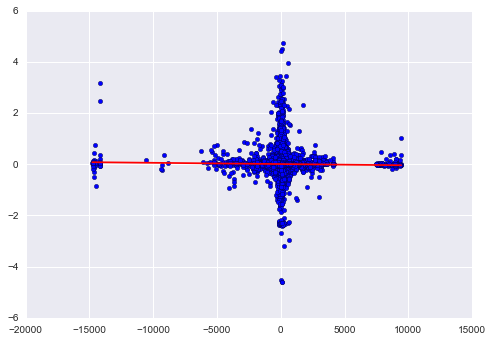

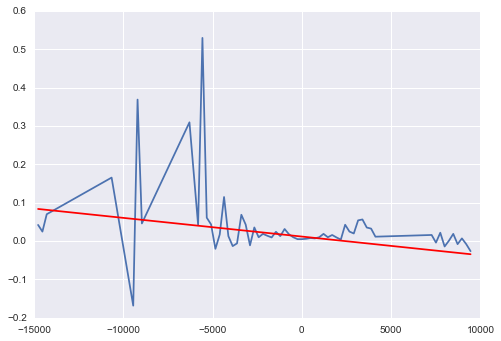

array([ -4.87077071e-06])

In [14]:
# Let's try a linear fit of this difference.

a = 50
b = 100
X = nbrdistance[:, b] / np.sqrt(b) - nbrdistance[:, a] / np.sqrt(a)
y = all_df.logerror.values
linear = linear_model.LinearRegression()
linear.fit(X.reshape(-1,1),y)
yp = linear.predict(X.reshape(-1,1))
error = np.abs(yp - y)
error = np.mean(error)
print(error)

relerror = (error - origerror) / error
print(relerror)

plt.scatter(X,y)
Xp = np.arange(np.amin(X), np.amax(X)).reshape(-1,1)
plt.plot(Xp, linear.predict(Xp), color = 'red')
plt.show()

bins = makebins(X, nbins = 100)
all_df['bins'] = bins
grouped_df = all_df.groupby('bins').median()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.plot(Xp, linear.predict(Xp), color = 'red')
plt.show()

linear.coef_

0.0679118640611
0.000196821802011


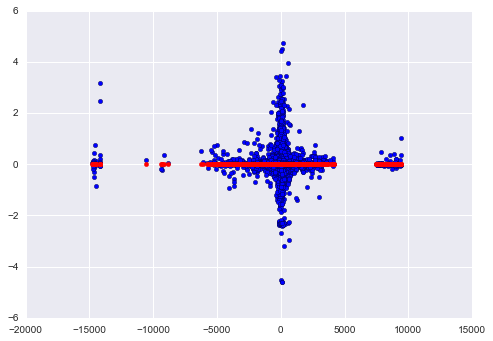

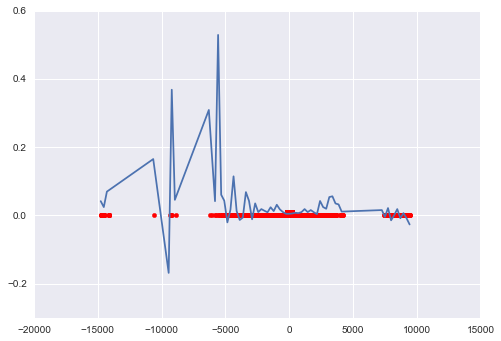

array([  1.46158754e-07])

In [15]:
# Let's try a linear fit on only certain range of this difference.

a = 50
b = 100
X = nbrdistance[:, b] / np.sqrt(b) - nbrdistance[:, a] / np.sqrt(a)

lowcutoff = -200
highcutoff = 200
indices = (X > lowcutoff) & (X < highcutoff)

X2 = X[indices]
y2 = all_df.logerror.values[indices]

linear = linear_model.LinearRegression()
linear.fit(X2.reshape(-1,1),y2)
yp = np.zeros(len(X))
yp[indices] = linear.predict(X2.reshape(-1,1))

error = np.abs(yp - y)
error = np.mean(error)
print(error)

relerror = (error - origerror) / error
print(relerror)

plt.scatter(X,y)
Xp = np.arange(np.amin(X), np.amax(X)).reshape(-1,1)
plt.scatter(X, yp, color = 'red')
plt.show()

bins = makebins(X, nbins = 100)
all_df['bins'] = bins
grouped_df = all_df.groupby('bins').median()
plt.plot(grouped_df.index.values, grouped_df.logerror.values)
plt.scatter(X, yp, color = 'red')
plt.show()

linear.coef_

0.0676156413722
-0.00418329468895


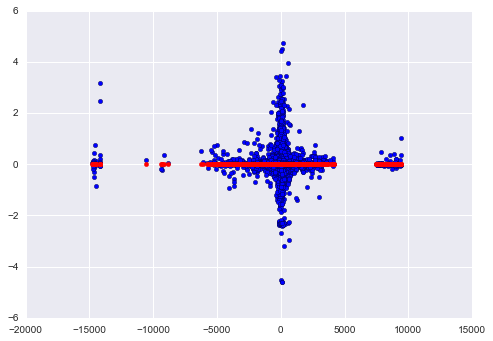

In [16]:
# Try a simple constant replacement for those value with difference in right range.

a = 50
b = 100
X = nbrdistance[:, b] / np.sqrt(b) - nbrdistance[:, a] / np.sqrt(a)
y = all_df.logerror.values
yp = np.zeros(len(y))


indices = (X > -500) & (X < 500)
vals = y[indices]
yp[indices] = np.median(vals)
error = np.abs(yp - y)
error = np.mean(error)
print(error)

relerror = (error - origerror) / error
print(relerror)

plt.scatter(X,y)
plt.scatter(X, yp, color = 'red')
plt.show()

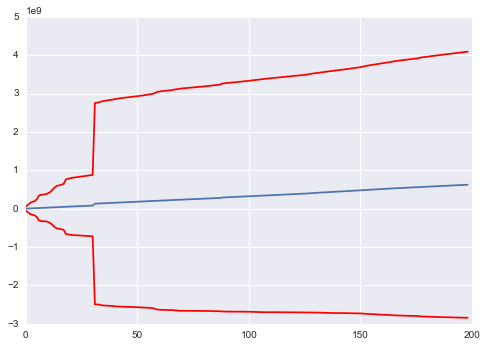

In [17]:
meandistance = np.mean(nbrdistance**2, axis = 0)
stddistance = np.std(nbrdistance**2, axis = 0)
plt.plot(meandistance)
plt.plot(meandistance + stddistance, color = 'red')
plt.plot(meandistance - stddistance, color = 'red')
plt.show()

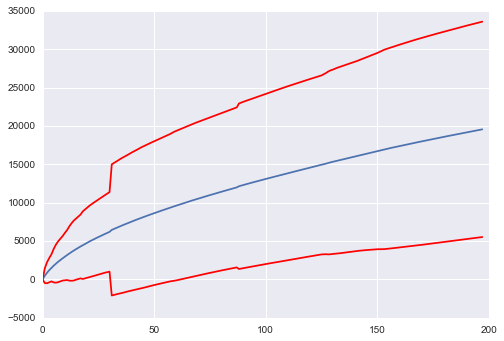

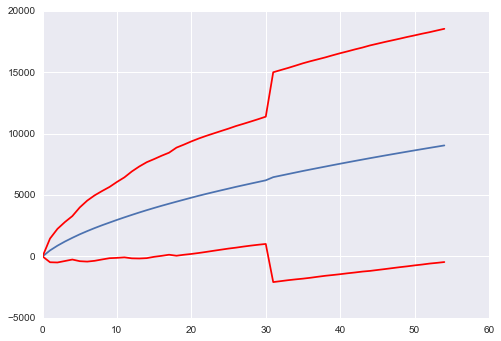

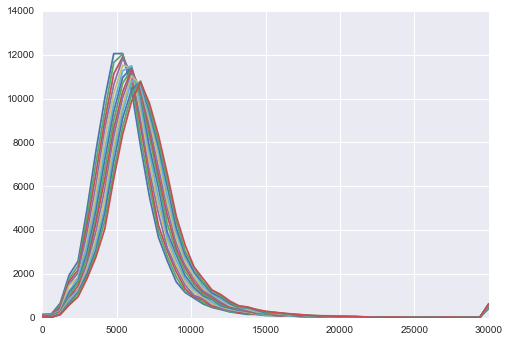

In [18]:
# Get information on total difference for different numbers of neighbors.

numrows, numcols = nbrdistance.shape
X = nbrdistance[:, 1:] - nbrdistance[:, :-1]
numintervals = range(numcols - 1)

# Get graphs of average plus/minus standard deviation.

averages = []
stddev = []

for numint in numintervals:
    Y = X[:, :numint].copy()
    Y = np.sum(Y, axis = 1)
    averages.append(np.mean(Y))
    stddev.append(np.std(Y))
    
averages = np.array(averages)
stddev = np.array(stddev)

plt.plot(averages)
plt.plot(averages + stddev, color = 'red')
plt.plot(averages - stddev, color = 'red')
plt.show()

plt.plot(averages[:55])
plt.plot(averages[:55] + stddev[:55], color = 'red')
plt.plot(averages[:55] - stddev[:55], color = 'red')
plt.show()

# Now get  profiles for certain numintervals.

numintervals = range(30,45,1)
lowcutoff = -1 * 10*1
highcutoff = 3 * 10**4
for numint in numintervals:
    Y = X[:, :numint].copy()
    Y = np.sum(Y,axis = 1)
    Y[Y < lowcutoff] = lowcutoff
    Y[Y > highcutoff] = highcutoff
    Y = makebins(Y, nbins = 50)
    values, counts = np.unique(Y, return_counts = True)
    plt.plot(values, counts)
plt.show()

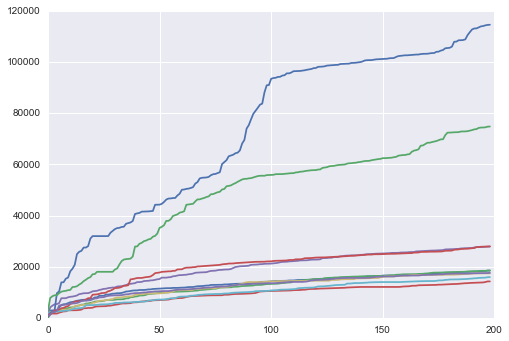

array([40842, 22816, 77693, 52043, 67792, 73778, 17814, 17884, 58830, 57881])

In [19]:
# Look at some graphs of neighbordistance.

rows = np.random.randint(len(nbrdistance), size = 10)

Y = nbrdistance[rows]
for row in Y:
    plt.plot(row)
plt.show()

rows

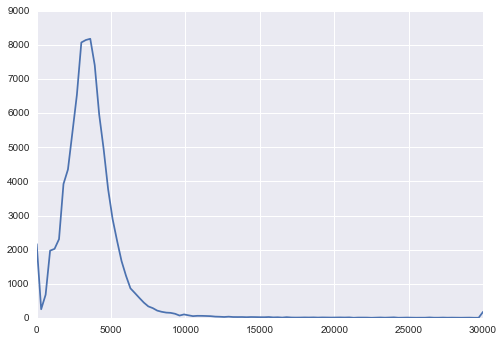

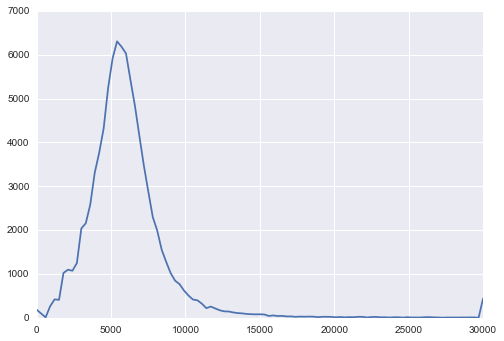

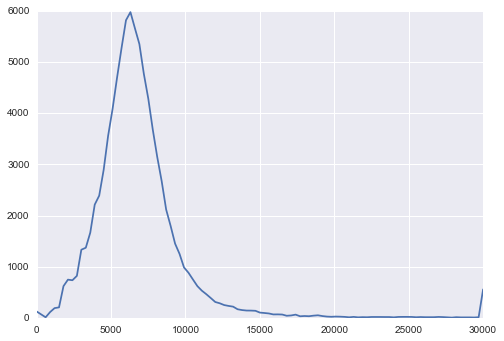

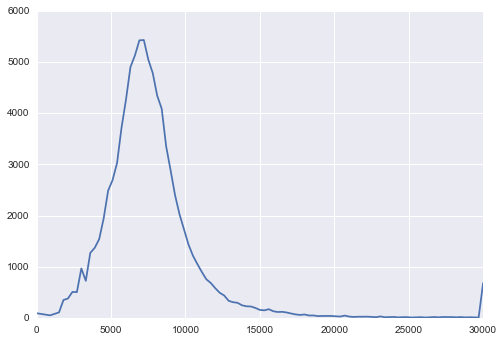

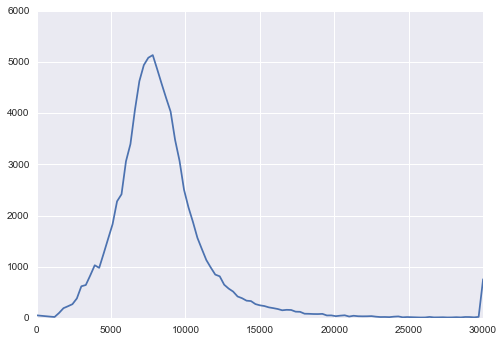

In [20]:
nbrnumbers = [10, 25, 31, 38, 45]

for nbrnumber in nbrnumbers:
    X = nbrdistance[:, nbrnumber]
    X[X > 3 * 10**4] = 3 * 10**4
    X = makebins(X, nbins = 100)
    values, counts = np.unique(X, return_counts = True)
    plt.plot(values, counts)
    plt.show()


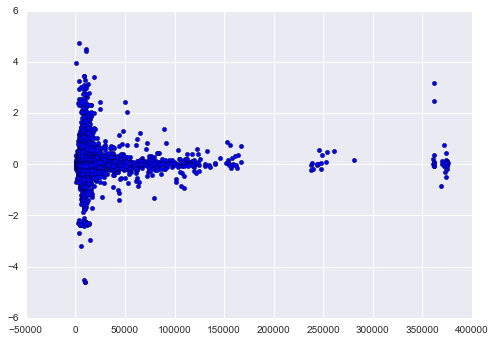

In [21]:
# Look at nbrdistance of 35 versus logerror

X = nbrdistance[:, 54]
y = all_df.logerror.values

plt.scatter(X, y)
plt.show()

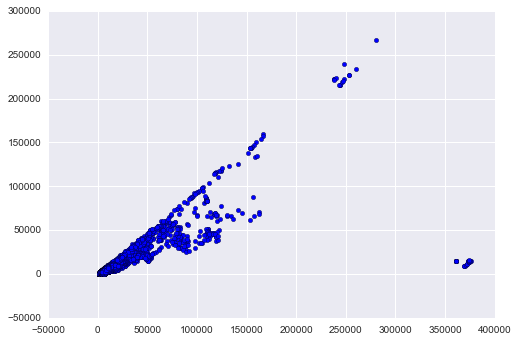

In [22]:
# Look at nbrdistance of 35 versus logerror

X = nbrdistance[:, 54]
y = nbrdistance[:, 24]

plt.scatter(X, y)
plt.show()

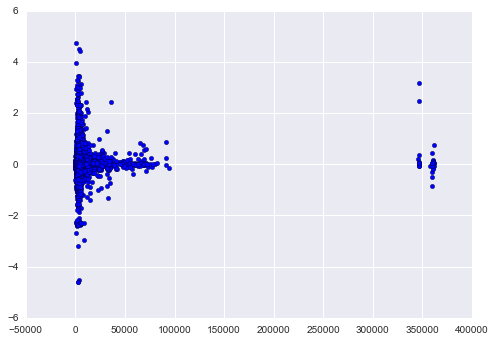

In [23]:
# Look at nbrdistance of 35 versus logerror

X = nbrdistance[:, 54] - nbrdistance[:, 24]
#X[X > 10**5] = 10**5
y = all_df.logerror.values

plt.scatter(X, y)
plt.show()

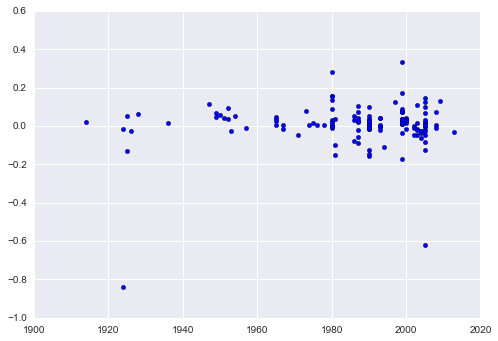

In [24]:
# Look at logerror vs yearbuilt for difference in nbrdistance small

filtervals = nbrdistance[:, 54] - nbrdistance[:, 24]
X = all_df.yearbuilt.values
y = all_df.logerror.values
indices = (filtervals < 0.5*10**3)
X = X[indices]
y = y[indices]

plt.scatter(X,y)
plt.show()

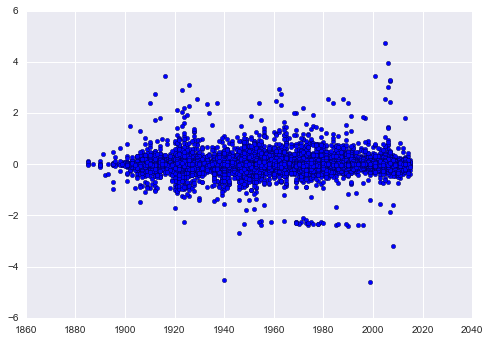

In [25]:
# Look at logerror vs yearbuilt for small nbrdistance for large neighbor number

filtervals = nbrdistance[:, 54]
X = all_df.yearbuilt.values
y = all_df.logerror.values
indices = (filtervals < 1*10**4)
X = X[indices]
y = y[indices]

plt.scatter(X,y)
plt.show()

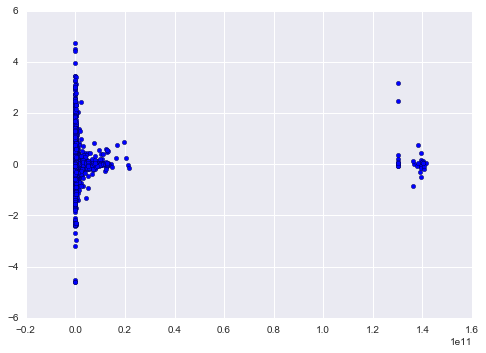

(89519,)
(89519,)


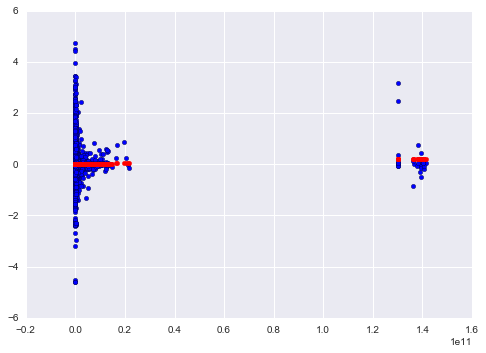

0.0679144696235


In [26]:
# Look at nbrdistance of 35 versus logerror

X = nbrdistance[:, 54]**2 - nbrdistance[:, 24]**2
#X[X < 0.6 * 10**11] = 0.6 * 10**11
y = all_df.logerror.values

plt.scatter(X, y)
plt.show()

print(X.shape)
print(y.shape)
linregr = linear_model.LinearRegression()
linregr.fit(X.reshape(-1,1),y.reshape(-1,1))
yp = linregr.predict(X.reshape(-1,1))
plt.scatter(X,y)
plt.scatter(X, yp, color = 'red')
plt.show()

error = np.abs(yp - y.reshape(-1,1))
error = np.mean(error)
print(error)
